In [1]:
!wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
!mkdir data
!tar -xvzf cifar-10-python.tar.gz -C data
!rm cifar-10-python.tar.gz

--2020-06-06 07:14:25--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  31.5MB/s    in 5.8s    

2020-06-06 07:14:31 (28.1 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

mkdir: cannot create directory ‘data’: File exists
cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [2]:
!curl https://raw.githubusercontent.com/snatch59/load-cifar-10/master/load_cifar_10_alt.py > load_cifar.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3493  100  3493    0     0   7626      0 --:--:-- --:--:-- --:--:--  7626


In [0]:
from load_cifar import load_data
import numpy as np
from skimage.transform import resize
import torchvision.models as models
import torch
import matplotlib.pyplot as plt

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [0]:
cifar_10_dir = 'data/cifar-10-batches-py'
(x_train, y_train), (x_test, y_test) = load_data(cifar_10_dir)

In [0]:
data_size = 10000
x_train = x_train[:data_size]
y_train = y_train[:data_size].reshape((data_size))
del x_test
del y_test

In [0]:
def to_one_hot(x, num_classes):
    b = np.zeros((len(x), num_classes), dtype=np.float32)
    b[np.arange(len(x)), x] = 1
    return b

In [0]:
x_train = torch.tensor(x_train.reshape(-1, 3, 32, 32), dtype=torch.float32) / 255
y_train = torch.tensor(to_one_hot(y_train, 10))

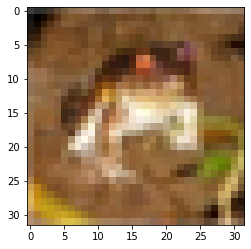

In [74]:
 plt.imshow((x_train[0]).reshape(32, 32, 3))

In [75]:
x_train[0]

tensor([[[0.2314, 0.2431, 0.2471,  ..., 0.3647, 0.5137, 0.4039],
         [0.3020, 0.4902, 0.3882,  ..., 0.4392, 0.2941, 0.5216],
         [0.4118, 0.2706, 0.5333,  ..., 0.5804, 0.4863, 0.4039],
         ...,
         [0.2118, 0.1294, 0.3373,  ..., 0.5216, 0.3608, 0.2157],
         [0.6039, 0.4784, 0.3686,  ..., 0.2667, 0.3137, 0.1569],
         [0.0510, 0.3804, 0.2078,  ..., 0.3608, 0.2980, 0.6863]],

        [[0.5059, 0.4157, 0.5569,  ..., 0.5255, 0.3647, 0.2235],
         [0.5686, 0.4471, 0.3490,  ..., 0.2157, 0.4353, 0.2353],
         [0.0549, 0.5725, 0.3373,  ..., 0.5882, 0.4431, 0.8196],
         ...,
         [0.3608, 0.6000, 0.4078,  ..., 0.4431, 0.2627, 0.6784],
         [0.5882, 0.4392, 0.7922,  ..., 0.5333, 0.4667, 0.1961],
         [0.5608, 0.4078, 0.2510,  ..., 0.5176, 0.6706, 0.5255]],

        [[0.3882, 0.6471, 0.4510,  ..., 0.3961, 0.2157, 0.5333],
         [0.3961, 0.2353, 0.5804,  ..., 0.7020, 0.6353, 0.3255],
         [0.5529, 0.4000, 0.2549,  ..., 0.4196, 0.7412, 0.

In [76]:
torch.max(x_train[0])

tensor(1.)

In [0]:
class CifarCNN (torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.cnn1 = torch.nn.Conv2d(3, 16, 3)  # 32 -> 30
    self.cnn2 = torch.nn.Conv2d(16, 32, 3, stride=2)  # 30 -> 14
    self.cnn3 = torch.nn.Conv2d(32, 64, 3)  # 12
    self.cnn4 = torch.nn.Conv2d(64, 128, 3, stride=2)  # 5
    self.linear1 = torch.nn.Linear(5 * 5 * 128, 1000)
    self.linear2 = torch.nn.Linear(1000, 10)

  def forward(self, x):
    x = torch.nn.functional.relu(self.cnn1(x))
    x = torch.nn.functional.relu(self.cnn2(x))
    x = torch.nn.functional.relu(self.cnn3(x))
    x = torch.nn.functional.relu(self.cnn4(x))
    x = torch.flatten(x, start_dim=1)
    x = torch.nn.functional.dropout(torch.nn.functional.relu(self.linear1(x)), 0.2)
    x = torch.nn.functional.softmax(self.linear2(x))
    return x  

In [0]:
model = CifarCNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [105]:
epochs = 10
batch_size = 200
for epoch in range(epochs):
    losses = 0
    for i in range(0, len(x_train), batch_size):
        start_index = i
        end_index = i+batch_size
        
        x_batch = x_train[start_index:end_index].to(device)
        y_batch = y_train[start_index:end_index].to(device)

        optimizer.zero_grad()
        
        y_hat = model(x_batch)
        loss = torch.nn.functional.binary_cross_entropy(y_hat, y_batch)

        loss.backward()
        optimizer.step()

        losses += float(loss)

    print(loss.data.item())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


0.0034001735039055347
0.004774507600814104
0.0014191349036991596
0.0071908701211214066
0.00224521872587502
0.0042527844198048115
0.0071261003613471985
0.0051026903092861176
0.0019673118367791176
0.0037232644390314817


tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]])
tensor([[4.5197e-14, 1.0000e+00, 6.7609e-18, 1.7305e-10, 2.8026e-15, 4.5563e-19,
         2.0895e-13, 8.3858e-14, 5.2074e-18, 3.0914e-08],
        [3.1051e-15, 3.0417e-07, 9.9952e-01, 2.1197e-09, 4.8159e-04, 2.4406e-08,
         1.0602e-06, 1.6480e-11, 1.6010e-13, 2.4774e-10]], device='cuda:0')


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


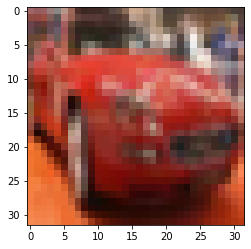

In [106]:
with torch.no_grad():
  index = 5
  x_test = x_train[index: index+2].to(device)
  y_test = y_train[index: index+2]
  plt.imshow(x_test[0].to('cpu').reshape(32, 32, 3))
  print(y_test)

  y_hat = model(x_test)
  
  print(y_hat)